# Neighborhood Components Analysis in Python

I wrote a simple implementation implemention of the neighborhood components analysis method (NCA) for learning a Mahalanobis distance measure that attempts to optimize the performance of a k-nearest-neighbor classifier. 

Basically the method introduces a transformation matrix $A$, which maps from the (raw) input space for the covariates ($X$) to a transformed space, i.e. $x_i^{trans} = Ax_i$. The transformation matrix $A$ is optimized using a differentiable cost function based on the stochastic assignment of neighbors, similar to the t-SNE method [1,2] (note that Geoff Hinton is a common author to both methods).

$p_{ij} = \frac{exp(-\|Ax_i - Ax_j\|)^2}{\sum_{k\neq i}exp(-\|Ax_i - Ax_k\|)^2}$, where $p_{ij}$ is the probability of sample $i$ choosing $j$ as its neighbor in the transformed space.

Now we can specify a cost function that pulls points from the same class closer together:

$f(A) = \sum_i \sum_{j\in C_i} p_{ij}. $, where $C_i$ is the class label of sample $i$.

Since the cost function is differentiable with respect to $A$ we can optimize it using gradient descent. For more details see references [1-3].


### References
[1] J. Goldberger, S. Roweis, G. Hinton, and R. Salakhutdinov. Neighbourhood components analysis.
In L. K. Saul, Y. Weiss, and L. Bottou, editors, Advances in Neural Information Processing
Systems 17, pages 513–520, Cambridge, MA, 2005. MIT Press.<br/>
[2] L. van der Maaten and G. E. Hinton, "Visualizing data using t-Sne," Journal of Machine Learning Research, vol. 9, pages 2579-2605, November 2008.<br/>
[3] http://www.wikicoursenote.com/wiki/Neighbourhood_Components_Analysis


## A simple example
I wanted to test my NCA implemention (and also just see what the algorithm does), so I tried it on a toy problem of just two four sample points and just two classes. I placed the sample point in rectangle, so that the nearest neighbor would lead to a misclassification (i.e. the nearest neighbor to each point is a point from the opposite class). While this is a simple problem for a classifier like logistic regression, k-nearest-neighbors would typically get an accuracy of zero here.

In [1]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.metrics import log_loss, accuracy_score
from nca import *
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier as kNN
import matplotlib
%matplotlib inline
import seaborn as sns; sns.set()
from matplotlib import animation, rc
from IPython.display import HTML

(-0.5, 0.5)

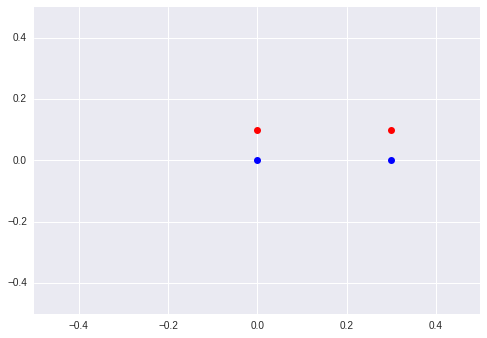

In [2]:
# place four points in a rectangle
#  and then view those points...
X = np.array( [[0,0], [0.,0.1], [0.3,0.1], [0.3, 0.0]] )
y = np.array( [0, 1, 1, 0] )

Xcl1 = X[y == 0]
Xcl2 = X[y == 1]
cl1, = sns.plt.plot(Xcl1[:,0], Xcl1[:,1], linestyle='', marker='o', color='b')
cl2, = sns.plt.plot(Xcl2[:,0], Xcl2[:,1], linestyle='', marker='o', color='r')
sns.plt.xlim((-0.5, 0.5))
sns.plt.ylim((-0.5, 0.5))

In [3]:
# This is a method to get the accuracy (using leave-one-out validation) of the data
def assess_perf(clf, X, y, scoring='accuracy', cv=None):
    if cv is None: cv = LeaveOneOut()
    scores = cross_val_score(clf, X, y, scoring=scoring, cv=cv)
    return np.mean(scores), np.std(scores)

knn = kNN(n_neighbors=1, weights='distance', algorithm='brute', n_jobs=-1)
print assess_perf(knn, X, y, scoring='accuracy')

(0.0, 0.0)


In [4]:
# We can initialise the transformation matrix to 
# anything we like, here we choose a diagonal matrix.
A = np.eye(X.shape[1])
# Store the transformed data, accuracies and the delta_A at each iteration
Xtrfmed = []
accs = []
diffs = []
n_elements_in_A = A.shape[0]*A.shape[1]

print 'NCA progress:',
for i in range(200): # 200 iterations
    if i%20 == 0: print '{:d}%'.format(int(i*100/200.)),
    A_prev = np.copy(A)
    # do  a simple step of the NCA method, matrix A will be updated
    nca(A, X, y, lr=0.5)
    Adiff = np.sum(np.abs(A_prev - A))/n_elements_in_A  
    Xtransformed = transform(A, X)
    Xtrfmed.append(Xtransformed)
    acc, _ = assess_perf(knn, Xtransformed, y, scoring='accuracy')
    accs.append(acc)
    diffs.append(Adiff)
    
print 'Done.'

NCA progress: 0% 10% 20% 30% 40% 50% 60% 70% 80% 90% Done.


The NCA ran for 200 iterations, let's plot the accuracy of the transformed data, and the change in $A$ with each iteration.

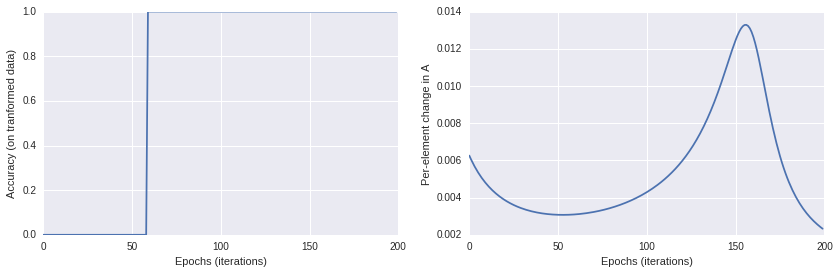

In [5]:
fig, (ax1, ax2) = sns.plt.subplots(1, 2, figsize=(14,4))
ax1.plot(accs)
ax2.plot(diffs)
ax1.set_xlabel('Epochs (iterations)')
ax2.set_xlabel('Epochs (iterations)')
ax1.set_ylabel('Accuracy (on tranformed data)')
ax2.set_ylabel('Per-element change in A')

We could actually stop after just $58$ iterations, as the transformationmatrix has already learned a good mapping with $100%$ classification accuracy by this point. The nice thing about this toy problem in this example is that we could solve it by hand: you want to either squeeze the feature-space in the x-direction (horizontal) or strength in the y-direction. By animating the learned representation at every iteration we can see what NCA actually did to the feature-space...

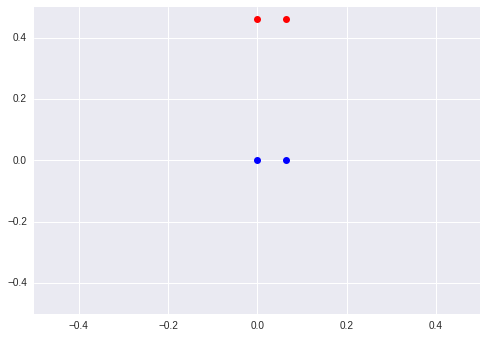

In [6]:
# First set up the figure, the axis, and the plot element we want to animate
fig = sns.plt.figure()
ax = sns.plt.axes(xlim=(-0.5, 0.5), ylim=(-0.5, 0.5))

#line, = ax.plot([], [], lw=2, color='b')
cl1, = ax.plot([],[], linestyle='', marker='o', color='b')
cl2, = ax.plot([],[], linestyle='', marker='o', color='r')
# initialization function: plot the background of each frame
def init():
    cl1.set_data([], [])
    cl2.set_data([], [])
    return [cl1, cl2,]

# animation function.  This is called sequentially
def animate(t):
    X_transformed_at_t = Xtrfmed[t]
    Xtcl1 = X_transformed_at_t[y == 0]
    Xtcl2 = X_transformed_at_t[y == 1]
    cl1.set_data(Xtcl1[:,0], Xtcl1[:,1])
    cl2.set_data(Xtcl2[:,0], Xtcl2[:,1])
    return [cl1, cl2, ]

# call the animator. 
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=range(len(Xtrfmed)), 
                               interval=50, blit=True)
sns.plt.grid(True)
HTML(anim.to_html5_video())